## **Вариант 3**

# Выполняем вспомогательные функции из шаблона:

In [ ]:
# @title Вспомогательные Функции (Часть Базового Кода)
# Убедитесь, что эта ячейка выполняется ПЕРЕД запуском кода варианта

# ... (здесь должны быть определения connect_db, close_db, execute_sql, load_df_from_sql и т.д.)

def execute_sql(sql_query, fetch=False):
    """Выполняет SQL-запрос и опционально возвращает результаты."""
    if not connection or not cursor:
        print("Нет подключения к БД.")
        return None
    try:
        # print(f"Выполнение SQL: {sql_query[:100]}...") # Отладка: показать начало запроса
        cursor.execute(sql_query)
        if fetch:
            results = cursor.fetchall()
            # print("Результаты получены.") # Отладка
            return results
        else:
            # Для запросов не SELECT (CREATE, DROP, INSERT, UPDATE, DELETE)
            # connection.commit() # Не требуется при autocommit=True
            # print("Запрос успешно выполнен (без fetch).") # Отладка
            return True # Возвращаем True для индикации успеха выполнения не-SELECT запроса
    except (Exception, Error) as error:
        print(f"Ошибка выполнения SQL: {error}")
        # connection.rollback() # Не требуется при autocommit=True
        return None # Возвращаем None для индикации ошибки

# --- Функция создания таблицы ---
def create_table(tbl_name):
    """Создает стандартную таблицу для данных продаж, удаляя ее, если она существует."""
    print(f"\nПопытка создать таблицу: {tbl_name}")
    # Шаг 1: Удалить таблицу, если она уже существует
    # Это важно для повторяемости: гарантирует, что мы начинаем с чистого листа
    # и не получим ошибку "table already exists".
    drop_success = execute_sql(f"DROP TABLE IF EXISTS {tbl_name};")
    if drop_success is None: # Проверяем, не было ли ошибки при DROP
        print(f"Не удалось выполнить DROP TABLE для {tbl_name}. Создание таблицы отменено.")
        return # Прерываем создание, если DROP не удался

    # Шаг 2: Определить SQL-запрос для создания таблицы
    # Структура таблицы (колонки и типы данных) соответствует анализу
    # из исходной практической работы. Имя таблицы берется из аргумента tbl_name.
    create_query = f"""
    CREATE TABLE {tbl_name} (
        id INTEGER PRIMARY KEY,         -- Уникальный идентификатор, первичный ключ
        quantity INTEGER,               -- Количество
        cost NUMERIC(10, 2),            -- Стоимость (NUMERIC для точности)
        total_revenue NUMERIC(12, 2)    -- Общая выручка (NUMERIC для точности)
    );
    """
    print(f"Запрос на создание таблицы {tbl_name}:\n{create_query}")

    # Шаг 3: Выполнить SQL-запрос на создание таблицы
    create_success = execute_sql(create_query)
    if create_success:
        print(f"Таблица '{tbl_name}' успешно создана.")
    else:
        print(f"Не удалось создать таблицу '{tbl_name}'.")

# ... (здесь определения load_via_pandas, load_via_copy_file, load_via_copy_stringio и т.д.)

In [ ]:
# @title Вспомогательные Функции (Часть Базового Кода - УБЕДИТЕСЬ, ЧТО ЭТА ЯЧЕЙКА ВЫПОЛНЕНА!)

# ... (импорты, константы, connect_db, close_db, execute_sql, load_df_from_sql, create_table) ...

# --- Функции Загрузки Данных ---

def load_via_copy_stringio(df, tbl_name):
    """Загружает данные из DataFrame через StringIO, используя copy_expert."""
    # Проверка подключения и наличия данных
    if not connection or not cursor or df is None:
        print("Нет подключения к БД или DataFrame пуст.")
        return False # Возвращаем False при неудаче
    print(f"Загрузка данных в '{tbl_name}' с использованием copy_expert (StringIO)...")
    start_time = time.time()
    buffer = io.StringIO() # Создаем буфер в памяти
    # Записываем DataFrame в буфер как CSV, включая заголовок
    try:
        df.to_csv(buffer, index=False, header=True, sep=',')
    except Exception as e:
         print(f"Ошибка конвертации DataFrame в CSV: {e}")
         buffer.close() # Закрываем буфер при ошибке
         return False # Возвращаем False при неудаче
    buffer.seek(0) # Перематываем буфер в начало для чтения
    # Формируем SQL команду COPY
    sql_copy = f"COPY {tbl_name} FROM STDIN WITH (FORMAT CSV, HEADER TRUE, DELIMITER ',')"
    try:
        # Выполняем COPY, передавая буфер как файл
        cursor.copy_expert(sql=sql_copy, file=buffer)
        # connection.commit() # Не требуется при autocommit=True
        duration = time.time() - start_time
        print(f"Успешно: Загрузка (StringIO) в '{tbl_name}' завершена за {duration:.2f} сек.")
        return True # Возвращаем True при успехе
    except (Exception, Error) as error:
        print(f"ОШИБКА при выполнении copy_expert (StringIO) для '{tbl_name}': {error}")
        # connection.rollback() # Не требуется при autocommit=True
        return False # Возвращаем False при неудаче
    finally:
        buffer.close() # Гарантируем закрытие буфера в любом случае

def load_via_copy_file(file_path, tbl_name):
    """Загружает данные напрямую из CSV файла, используя copy_expert."""
    # Проверка подключения
    if not connection or not cursor:
       print("Нет подключения к БД.")
       return False # Возвращаем False при неудаче
    # Проверка существования файла
    if not os.path.exists(file_path):
        print(f"ОШИБКА: Файл '{file_path}' не найден.")
        return False # Возвращаем False при неудаче
    print(f"Загрузка данных в '{tbl_name}' с использованием copy_expert (file: {os.path.basename(file_path)})...")
    start_time = time.time()
    # Формируем SQL команду COPY
    sql_copy = f"COPY {tbl_name} FROM STDIN WITH (FORMAT CSV, HEADER TRUE, DELIMITER ',')"
    try:
        # Открываем файл для чтения и передаем его дескриптор в copy_expert
        with open(file_path, 'r', encoding='utf-8') as f:
            cursor.copy_expert(sql=sql_copy, file=f)
        # connection.commit() # Не требуется при autocommit=True
        duration = time.time() - start_time
        print(f"Успешно: Загрузка (file) в '{tbl_name}' завершена за {duration:.2f} сек.")
        return True # Возвращаем True при успехе
    except (Exception, Error) as error:
        print(f"ОШИБКА при выполнении copy_expert (file) для '{tbl_name}': {error}")
        # connection.rollback() # Не требуется при autocommit=True
        return False # Возвращаем False при неудаче

# ... (другие вспомогательные функции, если есть) ...

print("Вспомогательные функции определены.")

Вспомогательные функции определены.


In [ ]:
# @title Вспомогательные Функции (Часть Базового Кода - УБЕДИТЕСЬ, ЧТО ЭТА ЯЧЕЙКА ВЫПОЛНЕНА!)

# ... (импорты, константы, connect_db, close_db, execute_sql, create_table, ...) ...

# --- Функция загрузки данных из SQL в DataFrame ---
def load_df_from_sql(sql_query):
    """Выполняет SQL-запрос и загружает результаты в Pandas DataFrame."""
    # Проверяем наличие активного подключения
    if not connection: # Для read_sql_query достаточно объекта connection
        print("Нет подключения к БД для загрузки DataFrame.")
        return None # Возвращаем None при ошибке
    print(f"Загрузка данных из SQL в DataFrame: {sql_query[:100]}...") # Показываем начало запроса
    try:
        # Используем pandas.read_sql_query для выполнения запроса и создания DataFrame
        # Эта функция сама управляет курсором и соединением для чтения
        df = pd.read_sql_query(sql_query, connection)
        print(f"Успешно: Загружено {len(df)} строк в DataFrame.")
        return df # Возвращаем созданный DataFrame
    except (Exception, Error) as error:
        # Обрабатываем ошибки при выполнении запроса или создании DataFrame
        print(f"ОШИБКА при загрузке DataFrame из SQL: {error}")
        return None # Возвращаем None при ошибке

# ... (определения load_via_copy_stringio, load_via_copy_file и другие функции) ...

print("Вспомогательные функции определены.")

Вспомогательные функции определены.


# Приступаем к выполнению индивидуальных заданий

Успешное подключение к PostgreSQL
--- Запуск Варианта 3 (Упрощенная загрузка) ---

--- Задача 1: Создание таблиц ---
Таблица sales_small успешно создана или уже существует
Таблица sales_big успешно создана или уже существует

--- Задача 2: Загрузка данных из 'C:\Users\Пользователь\Desktop\SQL\upload_test_data.csv' в 'sales_small' ---
Данные из C:\Users\Пользователь\Desktop\SQL\upload_test_data.csv успешно загружены в sales_small

--- Задача 3: Загрузка данных из 'C:\Users\Пользователь\Desktop\SQL\upload_test_data_big.csv' в 'sales_big' (метод file) ---
Данные из C:\Users\Пользователь\Desktop\SQL\upload_test_data_big.csv успешно загружены в sales_big

--- Задача 4: SQL Анализ таблицы sales_small ---
Выполнение SQL запроса:

    SELECT COUNT(*) 
    FROM sales_big 
    WHERE cost < 1.00;
    

Результаты запроса (id, total_revenue):
(99650,)

--- Задача 5: Анализ и визуализация данных из sales_big с помощью Python ---
Получение данных для анализа и визуализации: SELECT total_revenue FROM

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_13112\3691946222.py:81: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, connection)


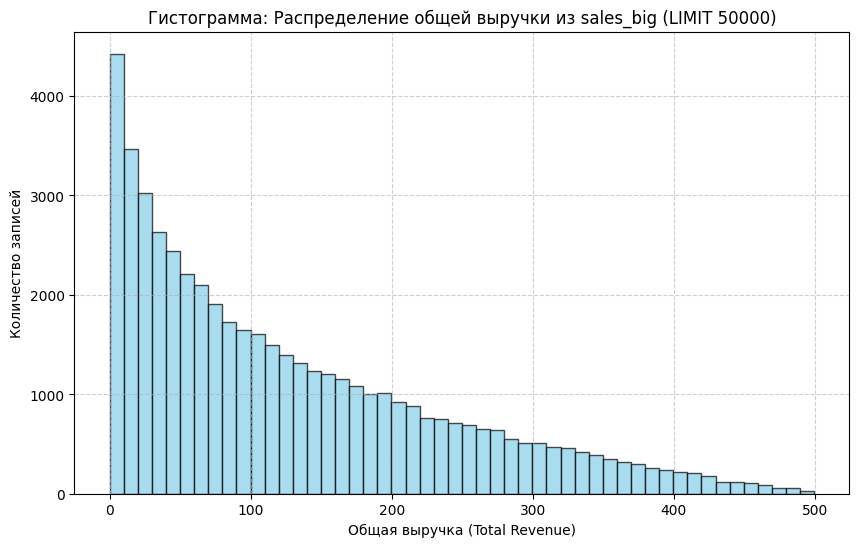


--- Вариант 3 Завершен ---

Соединение с базой данных закрыто.


In [ ]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import os
from io import StringIO

# --- Константы для подключения к PostgreSQL ---
DB_USER = "postgres"
DB_PASSWORD = "26102006"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "pr_8"       

# --- Константы для этого варианта ---
small_table_name = 'sales_small'
big_table_name = 'sales_big'
small_csv_path = r'C:\Users\Пользователь\Desktop\SQL\upload_test_data.csv'  
big_csv_path = r'C:\Users\Пользователь\Desktop\SQL\upload_test_data_big.csv'

# Функция для подключения к БД
def connect_db():
    try:
        connection = psycopg2.connect(
            dbname=DB_NAME,
            user=DB_USER,
            password=DB_PASSWORD,
            host=DB_HOST,
            port=DB_PORT
        )
        cursor = connection.cursor()
        print("Успешное подключение к PostgreSQL")
        return connection, cursor
    except Exception as e:
        print(f"Ошибка подключения к PostgreSQL: {e}")
        return None, None

# Функция для создания таблицы
def create_table(table_name):
    try:
        cursor.execute(f"""
        CREATE TABLE {table_name} (
            id INTEGER PRIMARY KEY,
            quantity INTEGER,
            cost NUMERIC(10, 2),
            total_revenue NUMERIC(12, 2)
        );
        """)
        connection.commit()
        print(f"Таблица {table_name} успешно создана или уже существует")
    except Exception as e:
        print(f"Ошибка при создании таблицы {table_name}: {e}")

# Функция для загрузки данных из файла
def load_via_copy_file(file_path, table_name):
    try:
        with open(file_path, 'r') as f:
            cursor.copy_expert(f"""
            COPY {table_name}(id, quantity, cost, total_revenue) 
            FROM STDIN WITH CSV HEADER DELIMITER ','
            """, f)
        connection.commit()
        print(f"Данные из {file_path} успешно загружены в {table_name}")
    except Exception as e:
        print(f"Ошибка при загрузке данных в {table_name}: {e}")

# Функция для выполнения SQL запросов
def execute_sql(query, fetch=False):
    try:
        cursor.execute(query)
        connection.commit()
        if fetch:
            return cursor.fetchall()
        return True
    except Exception as e:
        print(f"Ошибка выполнения SQL запроса: {e}")
        return None

# Функция для загрузки данных в DataFrame
def load_df_from_sql(query):
    try:
        return pd.read_sql(query, connection)
    except Exception as e:
        print(f"Ошибка загрузки данных в DataFrame: {e}")
        return None


connection, cursor = connect_db()

if not connection or not cursor:
    print("Подключение к базе данных неактивно. Пожалуйста, проверьте параметры подключения.")
else:
    print("--- Запуск Варианта 3 (Упрощенная загрузка) ---")

    # --- Задача 1: Настройка таблиц ---
    print("\n--- Задача 1: Создание таблиц ---")
    create_table(small_table_name)
    create_table(big_table_name)


    # --- Задача 2: Загрузка малых данных ---
    print(f"\n--- Задача 2: Загрузка данных из '{small_csv_path}' в '{small_table_name}' ---")
    if os.path.exists(small_csv_path):
        load_via_copy_file(small_csv_path, small_table_name)
    else:
        print(f"ОШИБКА: Файл '{small_csv_path}' не найден.")


    # --- Задача 3: Загрузка больших данных ---
    print(f"\n--- Задача 3: Загрузка данных из '{big_csv_path}' в '{big_table_name}' (метод file) ---")
    if os.path.exists(big_csv_path):
        load_via_copy_file(big_csv_path, big_table_name)
    else:
        print(f"ОШИБКА: Файл '{big_csv_path}' не найден. Загрузка не выполнена.")

        
    # --- Задача 4: SQL Анализ ---
    print("\n--- Задача 4: SQL Анализ таблицы sales_small ---")
    sql_query_task4 = f"""
    SELECT COUNT(*) 
    FROM sales_big 
    WHERE cost < 1.00;
    """
    print("Выполнение SQL запроса:")
    print(sql_query_task4)
    results_task4 = execute_sql(sql_query_task4, fetch=True)

    if results_task4 is not None:
        print("\nРезультаты запроса (id, total_revenue):")
        if results_task4:
            for row in results_task4:
                print(row)
        else:
            print("Запрос успешно выполнен, но не вернул строк.")
    else:
        print("Ошибка выполнения SQL запроса.")

    
    # --- Задача 5: Python Визуализация ---
    print("\n--- Задача 5: Анализ и визуализация данных из sales_big с помощью Python ---")
    sql_query_task5 = f"SELECT total_revenue FROM {big_table_name} LIMIT 50000;"
    print(f"Получение данных для анализа и визуализации: {sql_query_task5}")

    df_plot_data = load_df_from_sql(sql_query_task5)

    if df_plot_data is not None and not df_plot_data.empty:
        print(f"Загружено {len(df_plot_data)} строк для анализа и визуализации данных.")
    
        
        print("\nОсновные статистики для total_revenue:")
        print(df_plot_data['total_revenue'].describe())
    
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.hist(df_plot_data['total_revenue'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        ax.set_xlabel('Общая выручка (Total Revenue)')
        ax.set_ylabel('Количество записей')
        ax.set_title('Гистограмма: Распределение общей выручки из sales_big (LIMIT 50000)')
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.show()

    elif df_plot_data is not None and df_plot_data.empty:
        print("Запрос выполнен, но данные из sales_big для анализа и визуализации не получены.")
    else:
        print("Не удалось загрузить данные из sales_big для анализа и визуализации.")

    print("\n--- Вариант 3 Завершен ---")

    # Закрытие соединения
    if cursor:
        cursor.close()
    if connection:
        connection.close()
        print("\nСоединение с базой данных закрыто.")